# Sparse Approximations


The `gp.MarginalSparse` class implements sparse, or inducing point, GP approximations.  It works identically to `gp.Marginal`, except it additionally requires the locations of the inducing points (denoted `Xu`), and it accepts the argument `sigma` instead of `noise` because these sparse approximations assume white IID noise.

Three approximations are currently implemented, FITC, DTC and VFE.  For most problems, they produce fairly similar results.  These GP approximations don't form the full covariance matrix over all $n$ training inputs.  Instead they rely on $m < n$ *inducing points*, which are "strategically" placed throughout the domain.  Both of these approximations reduce the $\mathcal{O(n^3)}$ complexity of GPs down to $\mathcal{O(nm^2)}$ --- a significant speed up.  The memory requirements scale down a bit too, but not as much.  They are commonly referred to as *sparse* approximations, in the sense of being data sparse.  The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.  

A choice that needs to be made is where to place the inducing points.  One option is to use a subset of the inputs.  Another possibility is to use K-means.  The location of the inducing points can also be an unknown and optimized as part of the model.  These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points. 

For more information on these approximations, see [Quinonero-Candela+Rasmussen, 2006](http://www.jmlr.org/papers/v6/quinonero-candela05a.html) and [Titsias 2009](https://pdfs.semanticscholar.org/9c13/b87b5efb4bb011acc89d90b15f637fa48593.pdf).

## Examples

For the following examples, we use the same data set as was used in the `gp.Marginal` example, but with more data points.

In [1]:
import pymc3 as pm

import theano
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

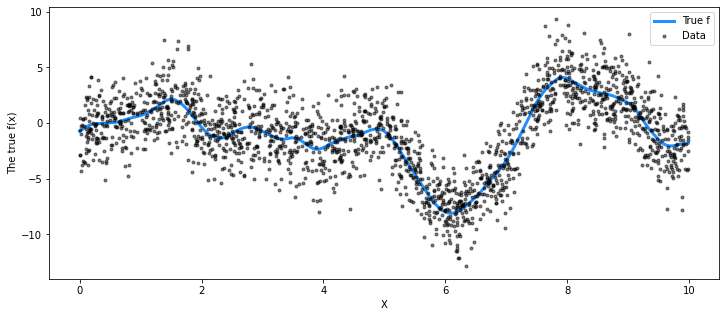

In [2]:
# set the seed
np.random.seed(1)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

### Initializing the inducing points with K-means

We use the NUTS sampler and the `FITC` approximation.

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util 
    Xu = pm.gp.util.kmeans_inducing_points(20, X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=σ)
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 731 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [4]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

/dependencies/pymc3/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


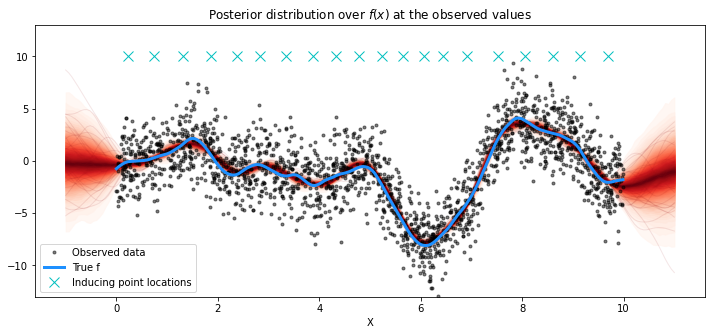

In [5]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

### Optimizing inducing point locations as part of the model

For demonstration purposes, we set `approx="VFE"`.  Any inducing point initialization can be done with any approximation.

In [6]:
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")
   
    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)
    
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y, noise=σ)
    
    mp = pm.find_MAP()

/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


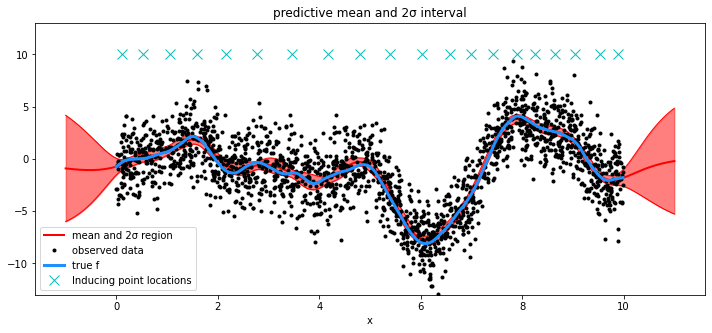

In [7]:
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3  3.9.0
theano 1.0.4
numpy  1.18.5
last updated: Mon Jun 15 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
